In [4]:
from timeit import default_timer as timer
start = timer()

In [5]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.datasets import cifar10 as cf10



import matplotlib.pylab as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.11.1


In [7]:
# Load image data from CIFAR-10 dataset
(train_images,train_labels),(test_images,test_labels) = cf10.load_data()

In [8]:
# Define helper function to view images
def show_images(train_images,class_names,train_labels,nb_samples=12, nb_row=4):
    plt.figure(figsize=(12,12))
    for i in range(nb_samples):
        plt.subplot(nb_row,nb_row,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i],cmap=plt.cm.binary)
        plt.xlabel(class_names[train_labels[i][0]])
    plt.show()
    

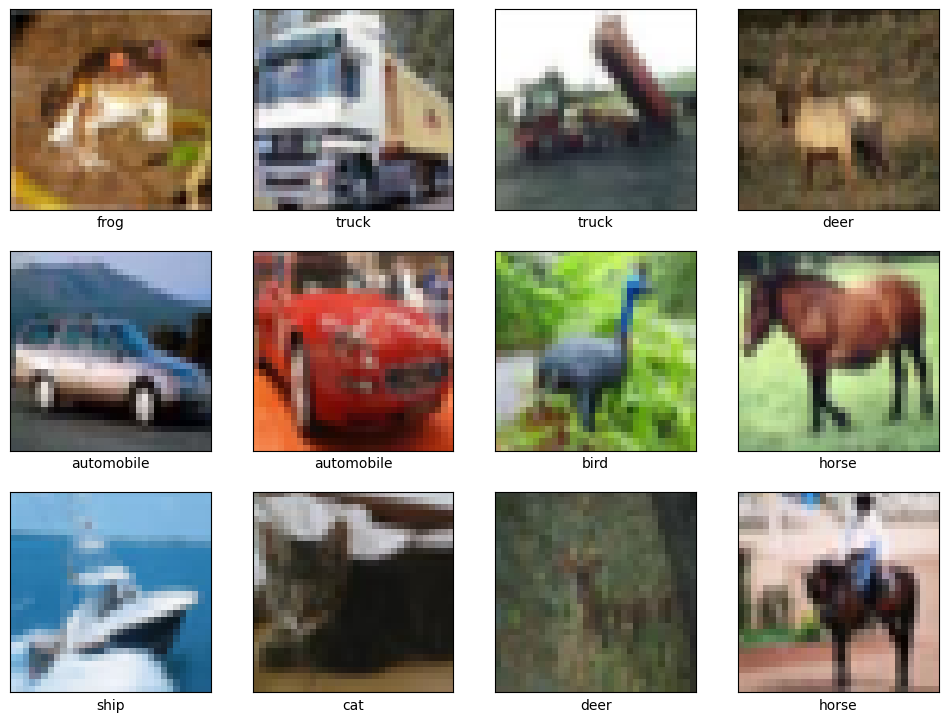

In [9]:
#Show samples images
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog','frog','horse','ship','truck']
show_images(train_images, class_names,train_labels)

In [10]:
# convert labels from text to one-hot vectors
train_labels = tf.keras.utils.to_categorical(train_labels, len(class_names))
test_labels = tf.keras.utils.to_categorical(test_labels, len(class_names))

In [12]:
# define the transfer model
INPUT_SHAPE = (32,32,3)
FILTER1_SIZE = 32
FILTER2_SIZE = 64
FILTER_SHAPE = (3,3)
POOL_SHAPE = (2,2)
FULLY_CONNECT_NUM = 128
NUM_CLASSES = len(class_names)
MAX_PIXEL_SIZE = 255

base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = tfl.Rescaling(1.0/MAX_PIXEL_SIZE)(inputs)
x = base_model(x, training = False)

x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(0.2)(x)

outputs = tfl.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()


In [26]:
# Define the mini Xception model architecture (Keras documentation)

#Constants
INPUT_SHAPE = (32,32,3)
FILTER1_SIZE = 32
FILTER2_SIZE = 64
FILTER_SHAPE = (3,3)
POOL_SHAPE = (2,2)
FULLY_CONNECT_NUM = 128
NUM_CLASSES = len(class_names)
MAX_PIXEL_SIZE = 255

inputs = tf.keras.Input(shape=INPUT_SHAPE)

#x = tfl.RandomFlip("horizontal")(inputs)
#x = tfl.RandomRotation(0.1)(x)

x = tfl.Rescaling(1.0/MAX_PIXEL_SIZE)(inputs)

x = tfl.Conv2D(FILTER1_SIZE,FILTER_SHAPE,strides=2,padding="same")(x)
x = tfl.BatchNormalization()(x)
x = tfl.Activation("relu")(x)

previous_block_activation = x #set aside residual

for size in [256, 512, 728]:
    x = tfl.Activation("relu")(x)
    x = tfl.SeparableConv2D(size,3,padding="same")(x)
    x = tfl.BatchNormalization()(x)
    
    x = tfl.Activation("relu")(x)
    x = tfl.SeparableConv2D(size,3,padding="same")(x)
    x = tfl.BatchNormalization()(x)
    
    x = tfl.MaxPooling2D(3, strides=2, padding="same")(x)
    
    #project residual
    residual = tfl.Conv2D(size,1,strides=2,padding="same")(previous_block_activation)
    
    x = tfl.add([x,residual]) # add back residual
    previous_block_activation = x #set aside next residual
    
x = tfl.SeparableConv2D(1024,3,padding="same")(x)
x = tfl.BatchNormalization()(x)
x = tfl.Activation("relu")(x)

x = tfl.GlobalAveragePooling2D()(x)

x = tfl.Dropout(0.7)(x)

outputs = tfl.Dense(NUM_CLASSES,activation="softmax")(x)

model = tf.keras.Model(inputs,outputs)

#tf.keras.utils.plot_model(model, show_shapes=True)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_2 (Rescaling)        (None, 32, 32, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 16, 16, 32)   896         ['rescaling_2[0][0]']            
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 16, 16, 32)  128         ['conv2d_4[0][0]']               
 rmalization)                                                                               

In [27]:
#Model compiling

BATCH_SIZE = 64
EPOCHS = 30
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
           ]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              loss='categorical_crossentropy',
              metrics=METRICS)


In [28]:
# model training

training_history = model.fit(x=train_images,
                             y=train_labels,
                             epochs=EPOCHS,
                             batch_size=BATCH_SIZE,
                             validation_data=(test_images, test_labels))


Epoch 1/30


2023-10-12 09:08:58.683582: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-12 09:08:58.684137: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-12 09:08:58.909329: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-12 09:08:58.909445: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

781/782 [============================>.] - ETA: 0s - loss: 1.3864 - accuracy: 0.5124 - precision: 0.6522 - recall: 0.3772

2023-10-12 09:09:40.722203: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-12 09:09:40.722275: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-12 09:09:40.739067: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-12 09:09:40.739138: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

782/782 [==============================] - 48s 52ms/step - loss: 1.3863 - accuracy: 0.5125 - precision: 0.6522 - recall: 0.3772 - val_loss: 1.9948 - val_accuracy: 0.4578 - val_precision: 0.5120 - val_recall: 0.4018
Epoch 2/30
782/782 [==============================] - 39s 50ms/step - loss: 0.9200 - accuracy: 0.6780 - precision: 0.7762 - recall: 0.5812 - val_loss: 1.0092 - val_accuracy: 0.6655 - val_precision: 0.7351 - val_recall: 0.6053
Epoch 3/30
782/782 [==============================] - 39s 50ms/step - loss: 0.7413 - accuracy: 0.7435 - precision: 0.8211 - recall: 0.6713 - val_loss: 0.7471 - val_accuracy: 0.7468 - val_precision: 0.8138 - val_recall: 0.6894
Epoch 4/30
782/782 [==============================] - 40s 51ms/step - loss: 0.6132 - accuracy: 0.7889 - precision: 0.8505 - recall: 0.7313 - val_loss: 0.8853 - val_accuracy: 0.7215 - val_precision: 0.7799 - val_recall: 0.6692
Epoch 5/30
782/782 [==============================] - 40s 51ms/step - loss: 0.5196 - accuracy: 0.8205 - pre

In [29]:
# model evaluation helper function

def show_performance_curve(training_result, metric, metric_label):
    train_perf = training_result.history[str(metric)]
    validation_perf = training_result.history['val_'+str(metric)]
    #intersection_idx = np.argwhere(np.isclose(train_perf,validation_perf,atol=1e-2)).flatten()[0]
    #intersection_value = train_perf[intersection_idx]
    
    plt.plot(train_perf, label=metric_label)
    plt.plot(validation_perf,label='val_'+str(metric))
    
    #plt.axvline(x=intersection_idx, color='r', linestyle='--', label='Intersection')
    
    # plt.annotate(f'Optimal value: {intersection_value:.4f}',
    #              xy=(intersection_idx,intersection_value),
    #              xycoords='data',
    #              fontsize=10,
    #              color = 'green')
    plt.xlabel('Epoch')
    plt.ylabel(metric_label)
    plt.legend(loc='lower right')

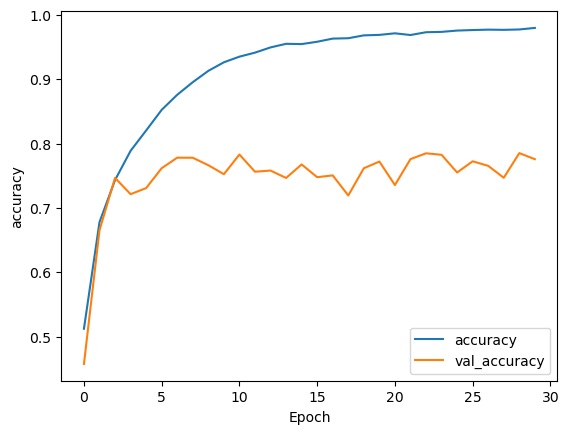

In [30]:
# Plot performance for "Accuracy" 
show_performance_curve(training_history,'accuracy','accuracy')

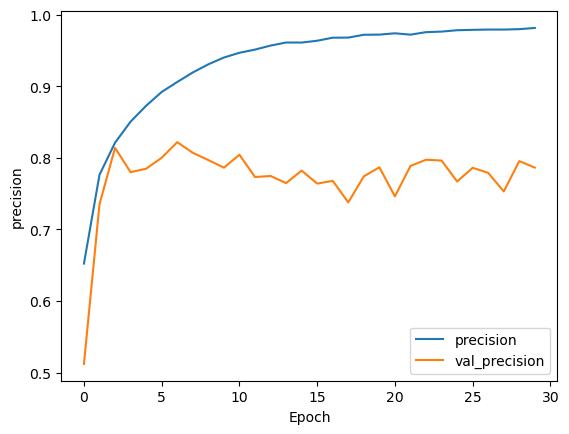

In [31]:
# Plot performance for "Precision" 
show_performance_curve(training_history,'precision','precision')

313/313 [==============================] - 2s 7ms/step


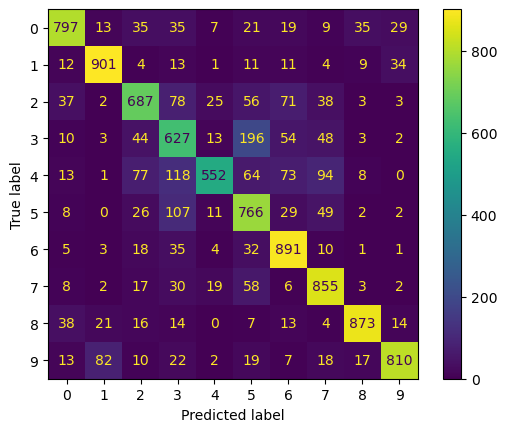

In [32]:
#Confusion matrix

test_predictions = model.predict(test_images)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(test_labels,axis=1)

cm = confusion_matrix(test_true_labels, test_predicted_labels)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()

In [33]:
end = timer()
print("--- %s seconds ---" % (end-start))

--- 1249.7788210590002 seconds ---
